In [90]:
import numpy as np
from numpy import dtype, float64, ndarray

CONSTS = {
    'R': 1.0,
    'CENTER': np.array([1.2, 1.2, 1.2]),
    'N': int(1e5),
    'A': 2.4
}

# Plot Funtion

In [91]:
import matplotlib.pyplot as plt

def plot(N:np.ndarray, expected:np.ndarray, std:np.ndarray, error, analitic, title) -> None:
    fig, ax = plt.subplots(3,1, figsize = (20,30))
    ax = ax.flatten()
    ax[0].plot(N, expected, 'b-', label='MC')
    ax[0].set_title(title)
    ax[0].axline((N[0], analitic), (N[-1], analitic), color='r', linestyle='-', label='Analitic')
    ax[0].set_xlabel('N')
    ax[0].set_xscale('log')
    ax[0].set_ylabel('expected')
    ax[0].set_xlim(N[0], N[-1])
    ax[0].legend()

    ax[1].plot(N, error, 'b-', label='MC')
    ax[1].axline((N[0], 0), (N[-1], 0), color='r', linestyle='-', label='Analitic')
    ax[1].set_xlabel('N')
    ax[1].set_xscale('log')
    ax[1].set_ylabel('error')
    ax[1].set_xlim(N[0], N[-1])
    ax[1].legend()

    ax[2].plot(N[1:], std[1:], 'b-')
    ax[2].set_xlabel('N')
    ax[2].set_ylabel('std')
    ax[2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].set_xlim(N[0], N[-1])


    plt.show()


# Sphere Volume

In [92]:
from numba import jit, njit

## SEED
np.random.seed = 42

def sphere_volume(R:float) -> float:
    return (4/3)*np.pi*R*R*R

@jit(nopython=True)
def sphere_volume_MC(R:float, A:float, center:np.ndarray[float] ,N:int) -> tuple[
    ndarray[tuple[int], dtype[float64]], ndarray[tuple[int], dtype[float64]], ndarray[tuple[int], dtype[float64]],
    ndarray[tuple[int], dtype[float64]]]:
    sqaure_vol:float = A**3
    sum:float = 0.0
    sum_of_squares:float = 0.0
    V = (4/3)*np.pi*R*R*R

    step = np.zeros(int(N / 100))
    expected = np.zeros(int(N / 100))
    variance = np.zeros(int(N / 100))
    error = np.zeros(int(N / 100))
    std = np.zeros(int(N / 100))

    for i in range(100, N+1, 100):
        sum = 0
        sum_of_squares = 0
        for j in range(1, i+1):
            # Random Point
            new_point = np.random.uniform(0, A, size=3)

            # result
            dist_sq = np.sum((new_point - center)**2, axis=0)
            multiplyer = 1.0 if dist_sq <= R*R else 0.0

            # Sums
            sum += sqaure_vol * multiplyer
            sum_of_squares += (sqaure_vol * multiplyer)**2

        # points = np.random.uniform(0, A, size=(N, 3))
        # dist_sq = np.sum((points - center)**2, axis=1)
        # values = (dist_sq <= R**2).astype(np.float64) * sqaure_vol
        # sum = np.sum(values)
        # sum_of_squares = np.sum(values**2)


        # Checkpoints
        idx = int(i/100) - 1
        step[idx] = i
        expected[idx] = sum/i
        variance[idx] = (sum_of_squares - (sum**2)/i)/(i-1)
        std[idx] = np.sqrt(variance[idx]/i)
        error[idx] = np.abs(sum/i - V)



    return step, expected, std, error

## Results

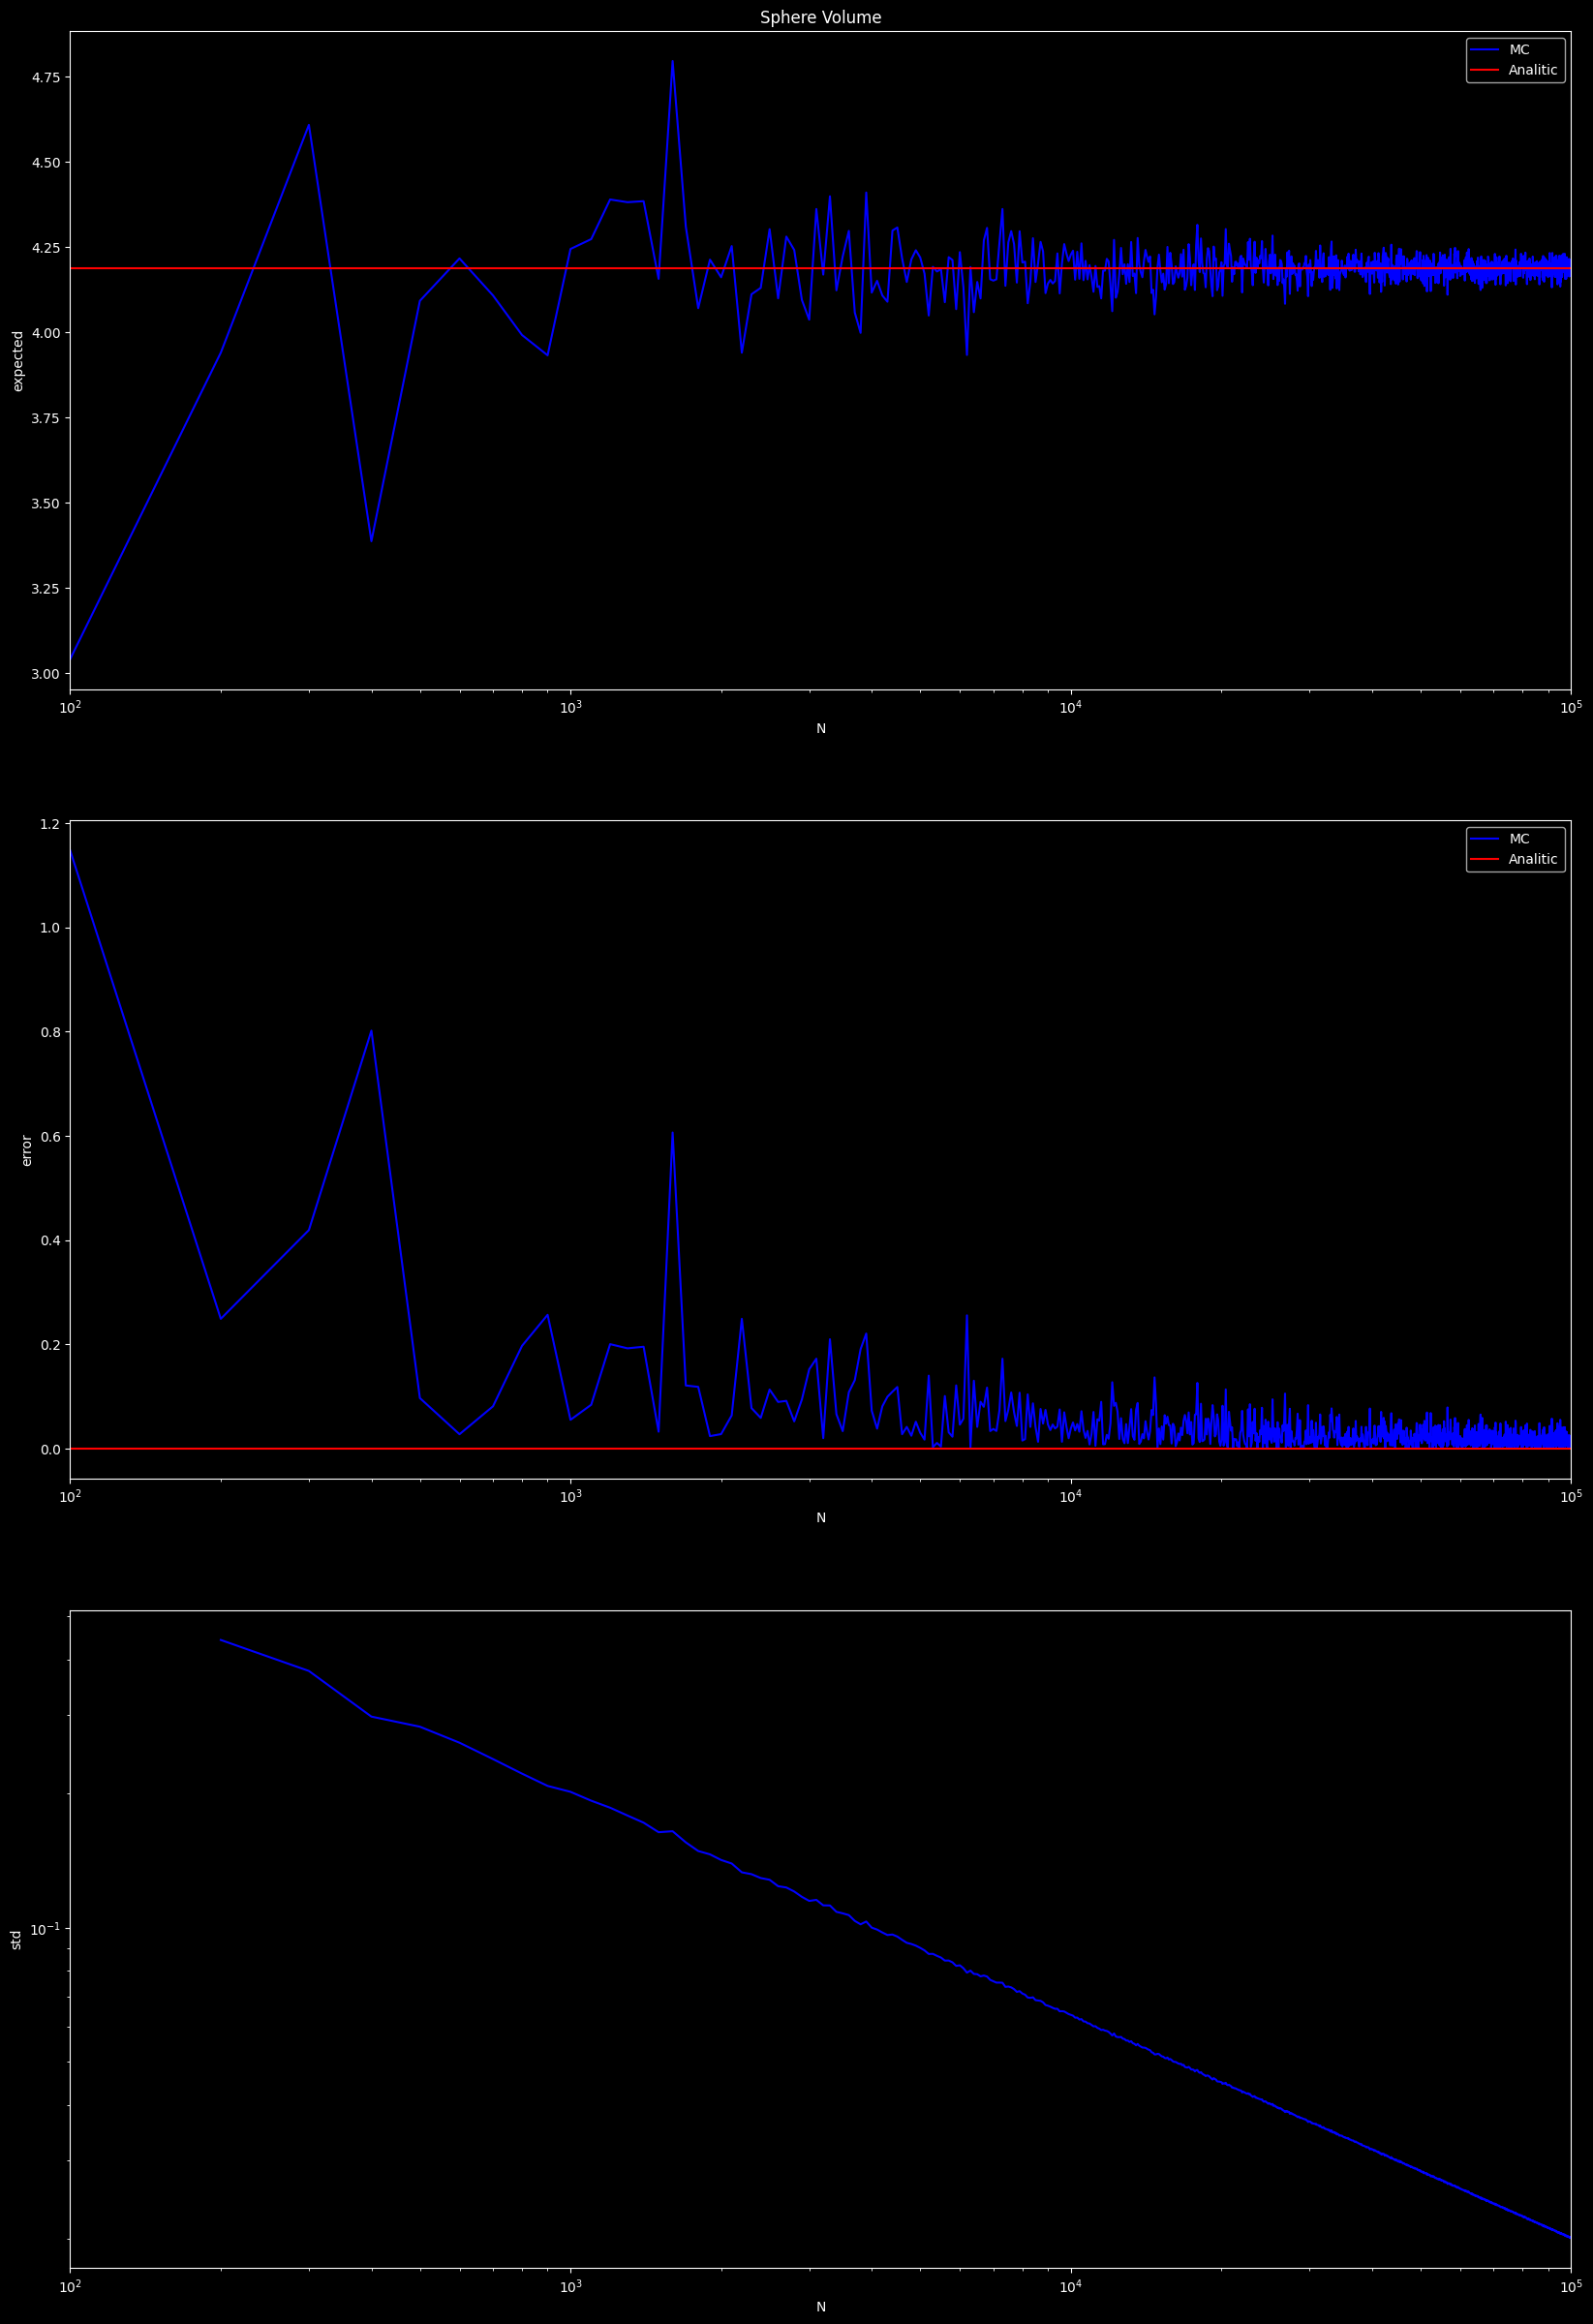

4.193925120001603


In [93]:
step, expected, std, error = sphere_volume_MC(CONSTS['R'], CONSTS['A'], CONSTS['CENTER'], CONSTS['N'])
v = sphere_volume(CONSTS['R'])

plot(step, expected, std, error, v, 'Sphere Volume')
print(expected[-1])

# Moment of Interia

In [94]:
import numpy as np
from numba import jit

def sphere_interia(R:float) -> float:
    return (2/5)*(4/3)*np.pi*R**5

@jit(nopython=True)
def sphere_interia_MC(R:float, A:float, center:np.ndarray, axis:np.ndarray, N:int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    sqaure_vol:float = A**3
    sum_val:float = 0.0
    sum_of_squares:float = 0.0
    V_exact = (2/5)*(4/3)*np.pi*R*R*R*R*R

    step = np.zeros(int(N / 100))
    expected = np.zeros(int(N / 100))
    variance = np.zeros(int(N / 100))
    error = np.zeros(int(N / 100))
    std = np.zeros(int(N / 100))


    for i in range(100, N+1, 100):
        sum_val = 0
        sum_of_squares = 0
        for j in range(i):
            new_point = np.random.uniform(0, A, size=3)

            dist_sq = np.sum((new_point - center)**2)
            multiplier = 1.0 if dist_sq <= R*R else 0.0

            dist_ax_sq = np.sum((new_point[0:2] - axis)**2)
            val = multiplier * sqaure_vol * dist_ax_sq

            sum_val += val
            sum_of_squares += val**2


        idx = int(i / 100) - 1
        step[idx] = i
        expected[idx] = sum_val / i
        variance[idx] = (sum_of_squares - (sum_val**2) / i) / (i - 1)
        std[idx] = np.sqrt(variance[idx] / i)
        error[idx] = np.abs(expected[idx] - V_exact)

    return step, expected, std, error

## Results

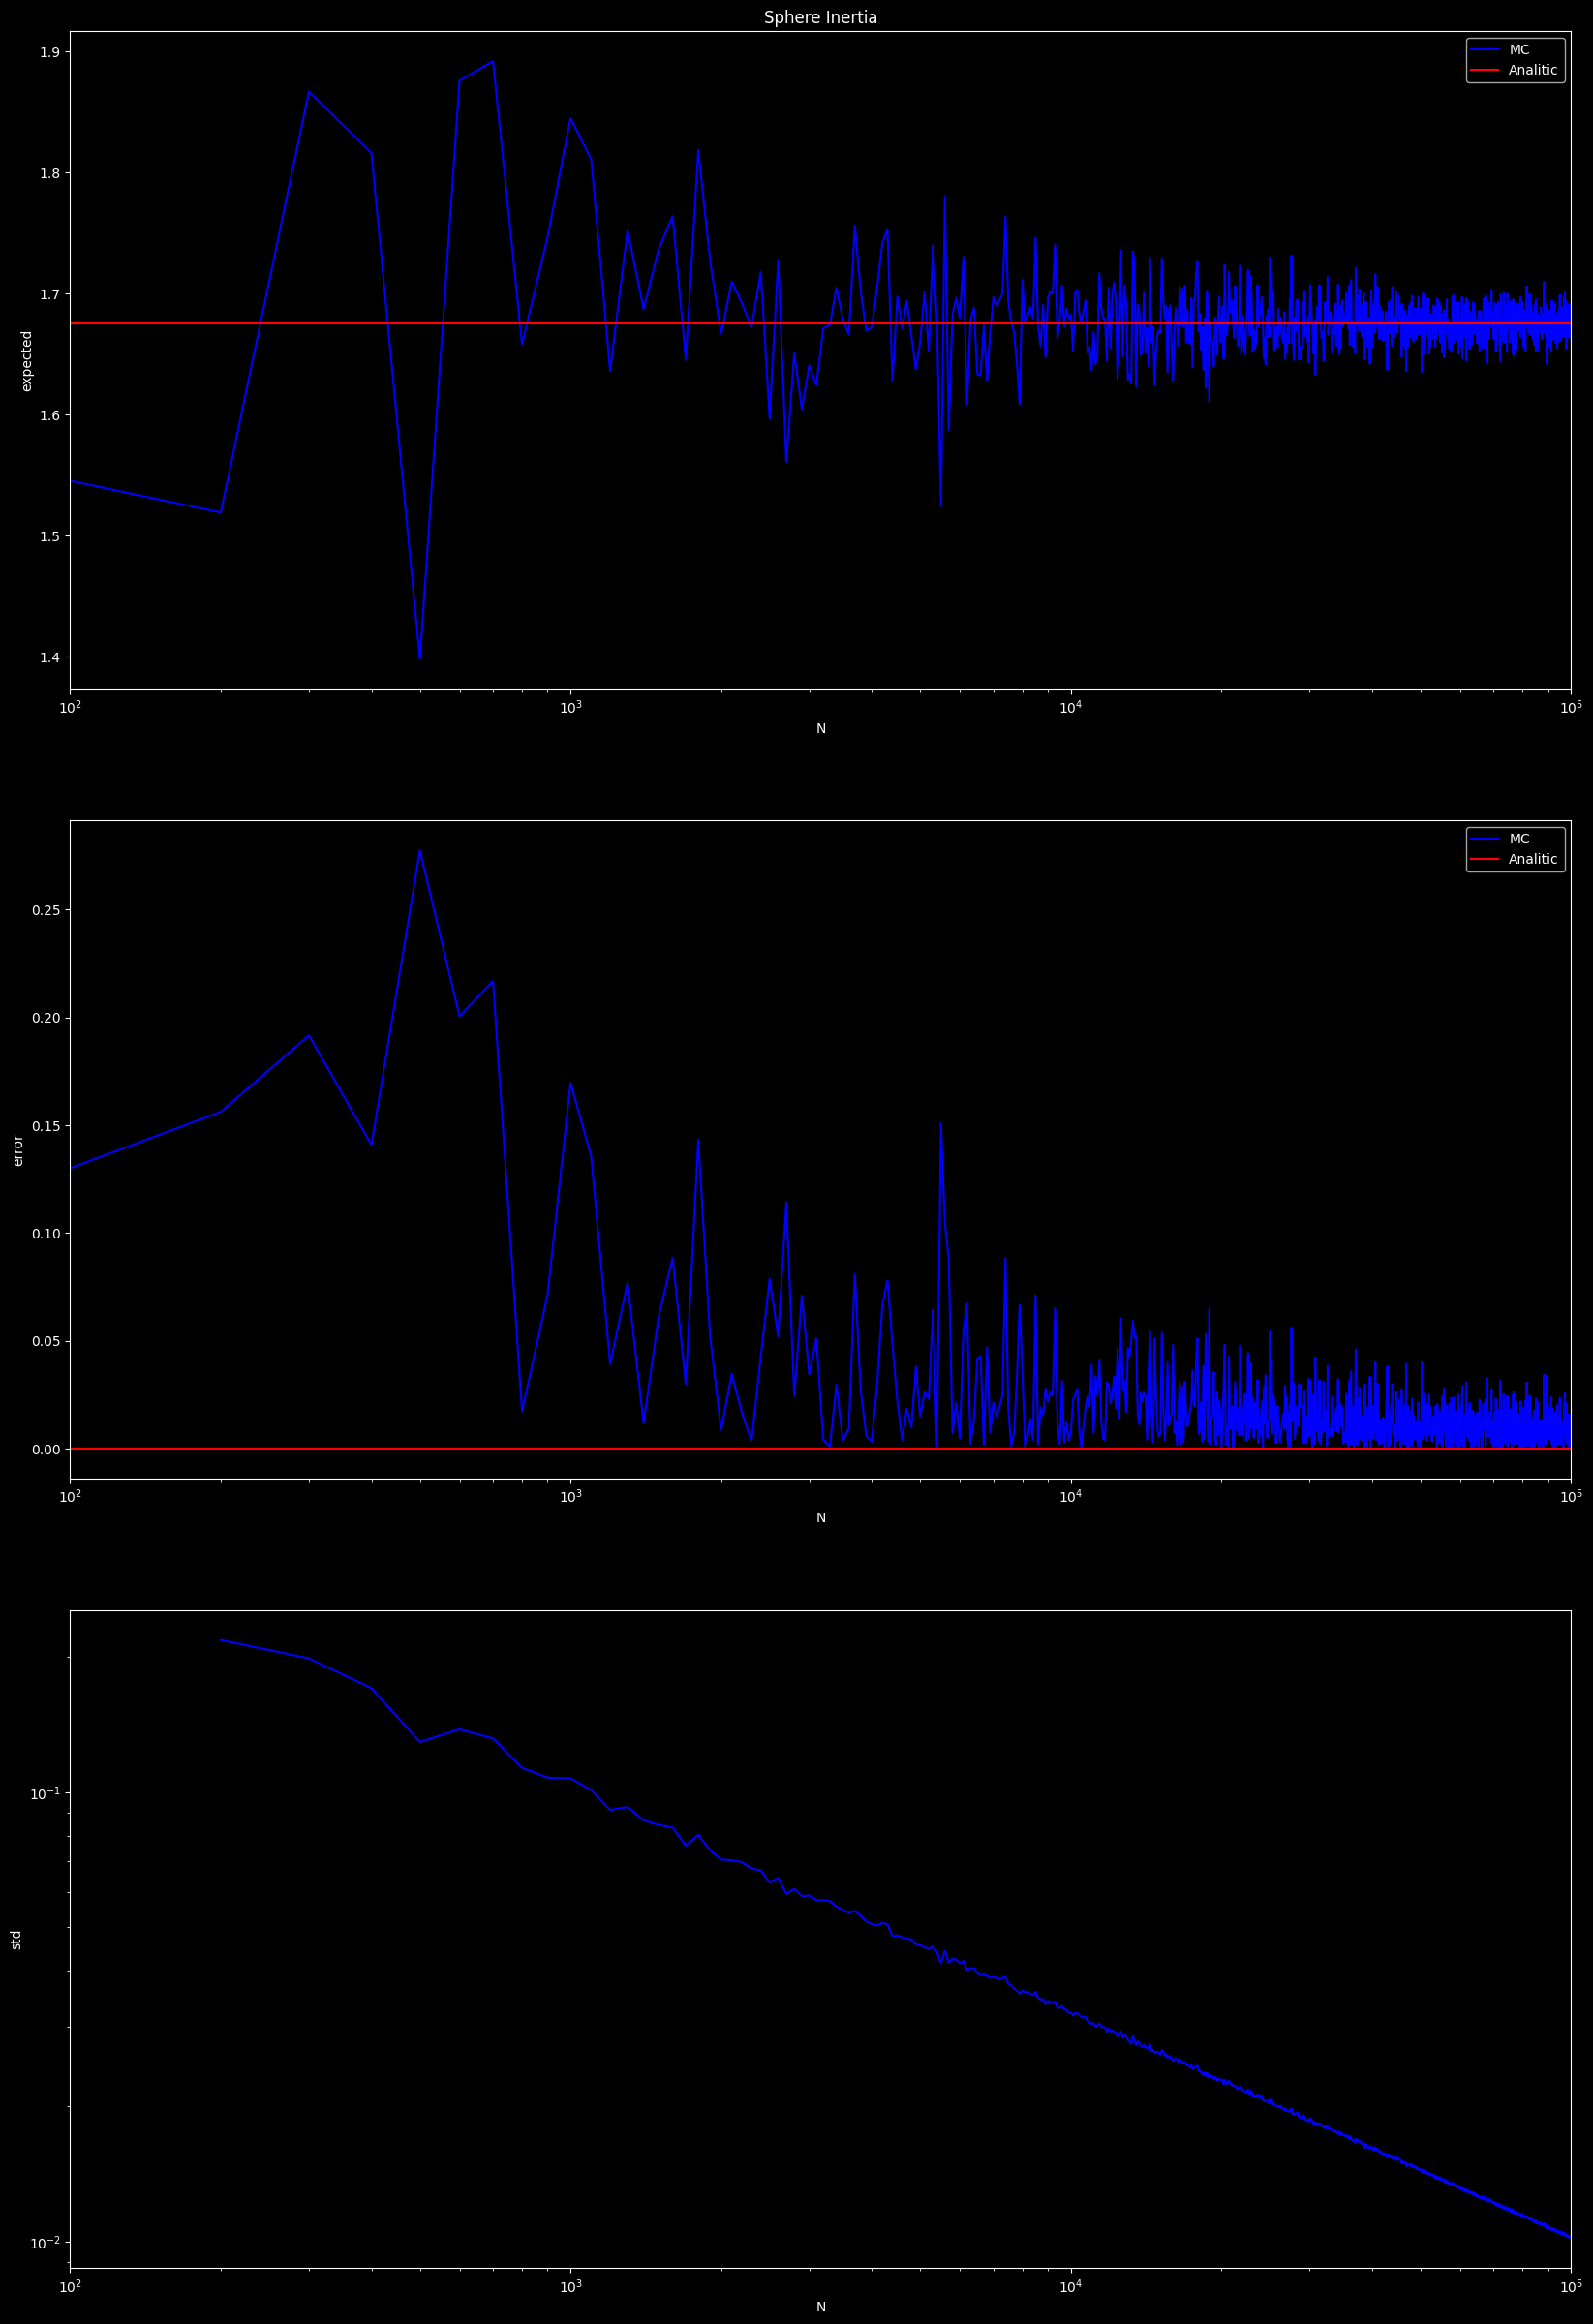

In [95]:
import matplotlib.pyplot as plt

step, expected, std, error = sphere_interia_MC(CONSTS['R'],CONSTS['A'], CONSTS['CENTER'], CONSTS['CENTER'][0:2], CONSTS['N'])
I = sphere_interia(CONSTS['R'])
plot(step, expected, std, error, I, 'Sphere Inertia')

# Steiner Theorem

In [ ]:
def steiner(I_0:float, m:float, d:float):
    return I_0 + m*d**2

p_0 = np.array([1.3, 1.2])
I_0 = sphere_interia(CONSTS['R'])
d = 0.1
M = sphere_volume(CONSTS['R'])

I2 = steiner(I_0, M, d)

step, expected, std, error = sphere_interia_MC(CONSTS['R'],CONSTS['A'], CONSTS['CENTER'], p_0, CONSTS['N'])

plot(step, expected, std, error, I2, 'Steiner Theorem')

# New Parameters

In [ ]:
CONSTS['A'] = 2
CONSTS['CENTER'] = np.array([1,1,1])

step, expected, std, error = sphere_volume_MC(CONSTS['R'], CONSTS['A'], CONSTS['CENTER'] ,CONSTS['N'])
plot(step, expected, std, error, v, 'Volume new params')


step, expected, std, error = sphere_interia_MC(CONSTS['R'],CONSTS['A'], CONSTS['CENTER'], CONSTS['CENTER'][0:2],CONSTS['N'])
plot(step, expected, std, error, I, 'Interia new params')